<h2>Importing required modules</h2>

In [1]:
import os #module that provide functions to interact with operating system
import re #module included in python used for string searching and manipulation
import math #module that provides access to the mathematical functions
import copy #This module provides generic shallow and deep copy operations 
import itertools
import collections #Collections in Python are containers that are used to store collections of data
import matplotlib.pyplot as plt # library for creating static, animated, and interactive visualizations 
import numpy as np #library used for working with arrays. 

<h2>Read and store dataset functions</h2>

In [2]:
# Document class to store email instances
class Document:
    text = ""
    wordFreqs = {}
    actualLabel = ""
    predictedLabel = ""

    def __init__(self, text, counter, actualLabel):
        self.text = text
        self.wordFreqs = counter
        self.actualLabel = actualLabel

    def getText(self):
        return self.text

    def getWordFreqs(self):
        return self.wordFreqs

    def getActualLabel(self):
        return self.actualLabel

    def getPredictedLabel(self):
        return self.predictedLabel

    def setPredictedLabel(self, guess_label):
        self.predictedLabel = guess_label


In [3]:
# extract words with their frequency in text
def bagOfWords(text):
    bagsofwords = collections.Counter(re.findall(r'\w+', text))
    return dict(bagsofwords)

In [4]:
# Extracts the vocabulary of all the text in a data set
def extractVocab(dataSet):
    all_text = ""
    v = []
    for x in dataSet:
        all_text += dataSet[x].getText()
    for y in bagOfWords(all_text):
        v.append(y)
    return v

<h2> Stopword Removal</h2>

In [5]:
# Set the stop words
def setStopWords():
    stops = []
    with open('stopwords.txt', 'r') as txt:
        stops = (txt.read().splitlines())
        stops = set(stops)
    return stops

# Remove stop words from data set and store in dictionary
def removeStopWords(stops, dataSet):
    filteredDataSet = copy.deepcopy(dataSet)
    for i in stops:
        for j in filteredDataSet:
            if i in filteredDataSet[j].getWordFreqs():
                del filteredDataSet[j].getWordFreqs()[i]
    return filteredDataSet

<h2> Create Dataset</h2>

In [6]:
# Read all text files in the given directory and construct the data set 
def createDataset(storage_dict, directory, actualLabel):
    for dir_entry in os.listdir(directory):
        dir_entry_path = os.path.join(directory, dir_entry)
        if os.path.isfile(dir_entry_path):
            with open(dir_entry_path, 'r', encoding="ansi", errors='ignore') as text_file:
                text = text_file.read()
                storage_dict.update({dir_entry_path: Document(text, bagOfWords(text), actualLabel)})

In [7]:
# Stores emails as dictionaries. file_name : email_Document
trainingSet = dict()
testSet = dict()
# Define classes for dataset
# ham = 0 , spam = 1 
classes = ["ham", "spam"]

# takes directories holding the data text files as paramters
def createDatasets(trainingSpamDir, trainingHamDir, testSpamDir, testHamDir):
    createDataset(trainingSet, trainingSpamDir, classes[1])
    createDataset(trainingSet, trainingHamDir, classes[0])
    createDataset(testSet, testSpamDir, classes[1])
    createDataset(testSet, testHamDir, classes[0])

createDatasets('train/spam', 'train/ham', 'test/spam', 'test/ham')

<h2>Train and Test Naive bayes </h2>

In [8]:
# Training 
def trainNB(training, priors, conditional):
    v = extractVocab(training)
    n = len(training)
    for c in classes:
        n_c = 0.0
        text_c = ""
        for i in training:
            if training[i].getActualLabel() == c:
                n_c += 1
                text_c += training[i].getText()
        priors[c] = float(n_c) / float(n)
        tokenFreqs = bagOfWords(text_c)
        #print("tokenFreqs")
        #print (tokenFreqs)
       
        # Calculate conditional probabilities for each token and sum using laplace smoothing and log-scale
        for t in v:
            # known word case
            if t in tokenFreqs:
                conditional.update({t + "_" + c: (float((tokenFreqs[t] + 1.0)) / float((len(text_c) + len(tokenFreqs))))})
            # unknown word case
            else:
                conditional.update({t + "_" + c: (float(1.0) / float((len(text_c) + len(tokenFreqs))))})


# Testing. 
# Returns classification guess
def applyNB(dataInstance, priors, conditional):
    score = {}
    for c in classes:
        score[c] = math.log10(float(priors[c]))
        for t in dataInstance.getWordFreqs():
            if (t + "_" + c) in conditional:
                score[c] += float(math.log10(conditional[t + "_" + c]))
    if score["spam"] > score["ham"]:
        return "spam"
    else:
        return "ham"


<h2> Defining function for Plot Confusion Matrix</h2>

In [9]:
#Evaluation of Model - Confusion Matrix Plot
def plotConfusionMatrix(cm, classes,normalize=False,title='Confusion Matrix'):
   
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    """
    plt.figure()
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
# Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

<h2>Training and Testing dataset</h2>

In [10]:
# Set the stop words list
stopWords = setStopWords()

# Filtered sets without stop words
filteredTrainingSet = dict()
filteredTestSet = dict()

# Set up data sets without stop words
filteredTrainingSet = removeStopWords(stopWords, trainingSet)
#print(filteredTrainingSet)
filteredTestSet = removeStopWords(stopWords, testSet)
#print (filtered_testSet)

# Dictionary to store conditional probability and prior
conditionalProbability = dict()
prior = dict()

# Train using the training data
trainNB(filteredTrainingSet, prior, conditionalProbability)

# Generating True Positive, False Positive, False Negative, True Negative
tp = 0 #true positive
tn =0 #true negetive
fp =0 #false positive
fn = 0 #false negetive
for i in filteredTestSet:
    filteredTestSet[i].setPredictedLabel(applyNB(filteredTestSet[i], prior, conditionalProbability))
    if filteredTestSet[i].getPredictedLabel() == filteredTestSet[i].getActualLabel() == "spam":
        tp += 1
    elif filteredTestSet[i].getPredictedLabel() == filteredTestSet[i].getActualLabel() == "ham":
        tn += 1
    elif filteredTestSet[i].getPredictedLabel() != filteredTestSet[i].getActualLabel() and filteredTestSet[i].getPredictedLabel() == "spam":
        fp += 1
    else: #filteredTestSet[i].getPredictedLabel() != filteredTestSet[i].getActualLabel() and filteredTestSet[i].getPredictedLabel() == "ham":
        fn += 1

Accuracy 95.1340276592112
Precision 93.65537130497476
Recall: 86.83155080213903


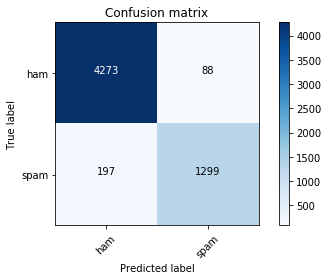

In [11]:
# Computing performance metrics
accuracy = (float(tp+tn) /float(tp+tn+fp+fn))*100   # (TP+TN)/(TP+TN+FP+FN)
precision = (float(tp) /float(tp+fp))*100        # (TP)/(TP+FP)
recall = ((tp) /float(tp+fn))*100               # (TP)/(TP+FN)
# formula to calculate f1_score = 2*(Precision*Recall/Precision+Recall)

# Printing performance metrics
print ("Accuracy",  accuracy)
print ("Precision", precision)
print ("Recall:", recall)


# Creating Confusion matrix
cm = np.array([tn, fp, fn, tp]).reshape(2,2)
plotConfusionMatrix(cm, classes, normalize=False, title='Confusion matrix')